# Inverse Problems

**TODOs**
- re-cap formulation from paper
- show targets in results

... intro ...
from {cite}`holl2019pdecontrol`

... inverse problems ...



## Learning to Control Incompressible Fluids 

This notebook will walk you through data generation, supervised network initialization and end-to-end training using our differentiable PDE solver, [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow). 
(_Note: this example uses an older version of Φ<sub>Flow</sub> (1.4.1)._)

The code below replicates the shape transitions (experiment 2 from the ICLR 2020 paper [Learning to Control PDEs with Differentiable Physics](https://ge.in.tum.de/publications/2020-iclr-holl/)). The experiment is described in detail in section D.2 of the [appendix](https://openreview.net/pdf?id=HyeSin4FPB).

**TODO, integrate?**
If you havn't already, check out the notebook on controlling Burgers' Equation. It covers the basics in more detail.

First we need to load phiflow and download the control code helpers (which will end up under `./src`) and some numpy arrays with intial shapes.

In [7]:
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@1.4.1

import matplotlib.pyplot as plt
from phi.flow import *

# this essentially copies over the code from https://github.com/holl-/PDE-Control
if not os.path.isfile('shapes/Shape_000000.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2020-iclr-holl/control.zip"
  print("Downloading, this can take a few minutes the first time...")
  urllib.request.urlretrieve(url, 'control.zip')
  import os
  os.system("unzip control.zip")

# now we can load the necessary phiflow libraries and helper functions
import sys; sys.path.append('./src')
from shape_utils import load_shapes, distribute_random_shape
from control.pde.incompressible_flow import IncompressibleFluidPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence, RefinedSequence


Could not load resample cuda libraries: CUDA binaries not found at /usr/local/lib/python3.7/dist-packages/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them


/usr/local/lib/python3.7/dist-packages/phi/tf/__init__.py:7: UserWarning: TensorFlow 2 is not fully supported by PhiFlow.
  warnings.warn('TensorFlow 2 is not fully supported by PhiFlow.')
/usr/local/lib/python3.7/dist-packages/phi/tf/flow.py:14: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


## Data Generation

Before starting the training, we have to generate a data set to train with. I.e., the goal is to pre-compute our a set of ground truth time sequences $u^*$. Due to the complexity of the training below, we'll use a staged approach that pre-trains a supervised network as a rough initialization, and then refines it to learn control looking further and further ahead into the future (i.e., being trained for longer simulation sequences). 

First, let's set up a domain and basic parameters of the data generation step.

In [9]:
domain = Domain([64, 64])  # 1D Grid resolution and physical size
step_count = 16  # how many solver steps to perform
dt = 1.0  # Time increment per solver step
example_count = 1000
batch_size = 100
data_path = 'shape-transitions'
pretrain_data_path = 'moving-squares'
shape_library = load_shapes('shapes')

The following cell creates the dataset we want to train our model on.
Each example consists of a start and target (end) frame which are generated by placing a random shape somewhere within the domain.

In [10]:
for scene in Scene.list(data_path): scene.remove()

for _ in range(example_count // batch_size):
    scene = Scene.create(data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    start = distribute_random_shape(domain.resolution, batch_size, shape_library)
    end__ = distribute_random_shape(domain.resolution, batch_size, shape_library)
    [scene.write_sim_frame([start], ['density'], frame=f) for f in range(step_count)]
    scene.write_sim_frame([end__], ['density'], frame=step_count)

shape-transitions/sim_000000
shape-transitions/sim_000100
shape-transitions/sim_000200
shape-transitions/sim_000300
shape-transitions/sim_000400
shape-transitions/sim_000500
shape-transitions/sim_000600
shape-transitions/sim_000700
shape-transitions/sim_000800
shape-transitions/sim_000900


Since this dataset does not contain any intermediate frames, it does not allow for supervised pretraining. This is because to pre-train a CFE, two consecutive frames are required and to pretrain an $OP_n$, three frames with distance $n/2$ are needed.

Instead, we create a second dataset which contains intermediate frames. This does not need to look like the actual dataset since it's only used for network initialization. Here, we linearly move a rectangle around the domain.

In [11]:
for scene in Scene.list(pretrain_data_path): scene.remove()

for scene_index in range(example_count // batch_size):
    scene = Scene.create(pretrain_data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    pos0 = np.random.randint(10, 56, (batch_size, 2))  # start position
    pose = np.random.randint(10, 56, (batch_size, 2))  # end position
    size = np.random.randint(6,  10,  (batch_size, 2))
    for frame in range(step_count+1):
        time = frame / float(step_count + 1)
        pos = np.round(pos0 * (1 - time) + pose * time).astype(np.int)
        density = AABox(lower=pos-size//2, upper=pos-size//2+size).value_at(domain.center_points())
        scene.write_sim_frame([density], ['density'], frame=frame)

moving-squares/sim_000000
moving-squares/sim_000100
moving-squares/sim_000200
moving-squares/sim_000300
moving-squares/sim_000400
moving-squares/sim_000500
moving-squares/sim_000600
moving-squares/sim_000700
moving-squares/sim_000800
moving-squares/sim_000900


## Supervised Initialization

In [12]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

The following cell trains all OP$_n \,\, \forall n\in\{2,4,8,16\}$.
The `ControlTraining` class is used to set up the optimization problem.

The loss for the supervised initialization is defined as the observation loss at the center frame.

$\boldsymbol L_o^\textrm{sup} = \left|\mathrm{OP}[o(t_i),o(t_j)] - u^*\left(\frac{t_i+t_j}{2}\right)\right|^2.$

Consequently, no sequence needs to be simulated (`sequence_class=None`) and an observation loss is required at frame $\frac n 2$ (`obs_loss_frames=[n // 2]`).
The pretrained network checkpoints are stored in `supervised_checkpoints`.

*Note: The next cell will run for some time. If you have a set of pretrained networks, you can skip it and load the pretrained networks instead (see instructions below).*

In [ ]:
supervised_checkpoints = {}

for n in [2, 4, 8, 16]:
    app = ControlTraining(n, IncompressibleFluidPDE(domain, dt),
                          datapath=pretrain_data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                          obs_loss_frames=[n//2], trainable_networks=['OP%d' % n],
                          sequence_class=None).prepare()
    for i in range(1000):
        app.progress()  # Run Optimization for one batch
    supervised_checkpoints['OP%d' % n] = app.save_model()

In [14]:
supervised_checkpoints

{'OP16': '/root/phi/model/control-training/sim_000003/checkpoint_00001000',
 'OP2': '/root/phi/model/control-training/sim_000000/checkpoint_00001000',
 'OP4': '/root/phi/model/control-training/sim_000001/checkpoint_00001000',
 'OP8': '/root/phi/model/control-training/sim_000002/checkpoint_00001000'}

In [15]:
# supervised_checkpoints = {'OP%d' % n: '../networks/shapes/supervised/OP%d_1000' % n for n in [2, 4, 8, 16]}

## CFE Pretraining with Differentiable Physics

To pretrain the CFE, we set up a simulation with a single step of the differentiable solver.

The following cell trains the CFE network from scratch. You can skip it an load the checkpoint by running the cell after.

In [ ]:
app = ControlTraining(1, IncompressibleFluidPDE(domain, dt),
                      datapath=pretrain_data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                      obs_loss_frames=[1], trainable_networks=['CFE']).prepare()
for i in range(1000):
    app.progress()  # Run Optimization for one batch
supervised_checkpoints['CFE'] = app.save_model()

In [17]:
# supervised_checkpoints['CFE'] = '../networks/shapes/CFE/CFE_2000'

Note that we have not actually set up a simulation for the training. To evaluate the quality of our current solutions, we can use the `ControlTraining` class again but this time passing a `sequence_class`.
With a sequence class, `ControlTraining` sets up the necessary physics steps and networks.
Example sequence classes are `StaggeredSequence` and `RefinedSequence`.

**TODO** , add preview?


## End-to-end Training with Differentiable Physics

To initiate an end-to-end training of the $CFE$ and all $OP_n$ networks with the differentiable physics loss , we create a new `ControlTraining` instance with the staggered execution scheme.

The following cell builds the computational graph with `step_count` solver steps without initializing the network weights.


In [18]:
staggered_app = ControlTraining(step_count, IncompressibleFluidPDE(domain, dt),
                                datapath=data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                                obs_loss_frames=[step_count], trainable_networks=['CFE', 'OP2', 'OP4', 'OP8', 'OP16'],
                                sequence_class=StaggeredSequence, learning_rate=5e-4).prepare()

App created. Scene directory is /root/phi/model/control-training/sim_000005 (INFO), 2021-03-03 09:56:12,572n

Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2021-03-03 09:56:12,575n

Partition length 16 sequence (from 0 to 16) at frame 8


/usr/local/lib/python3.7/dist-packages/phi/struct/context.py:18: UserWarning: struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.
  warnings.warn("struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Partition length 8 sequence (from 0 to 8) at frame 4
Partition length 4 sequence (from 0 to 4) at frame 2
Partition length 2 sequence (from 0 to 2) at frame 1
Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3
Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6
Partition length 2 sequence (from 4 to 6) at frame 5
Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7
Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12
Partition length 4 sequence (from 8 to 12) at frame 10
Partition length 2 sequence (from 8 to 10) at frame 9
Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11
Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14
Partition length 2 sequence (from 12 to 14) at frame 13
Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15
Execute -> 15
Execute -> 16
Target loss: Tensor("trued

The next cell initializes the networks using the supervised checkpoints and then trains all networks jointly. You can skip it and load the checkpoint by running the cell after. You can increase the number of optimization steps or execute the next cell multiple times to further increase performance.

*Note: The next cell will run for some time. You can skip the next two cells and load the pretrained networks instead.*

In [ ]:
staggered_app.load_checkpoints(supervised_checkpoints)
for i in range(1000):
    staggered_app.progress()  # Run staggered Optimization for one batch
staggered_checkpoint = staggered_app.save_model()

In [20]:
# staggered_checkpoint = {net: '../networks/shapes/staggered/all_53750' for net in ['CFE', 'OP2', 'OP4', 'OP8', 'OP16']}
# staggered_app.load_checkpoints(staggered_checkpoint)

Now that the network is trained, we can infer some trajectories from the test set.
This corresponds to Fig 5b and 18b from the [paper](https://openreview.net/pdf?id=HyeSin4FPB).

In [21]:
states = staggered_app.infer_all_frames(test_range)

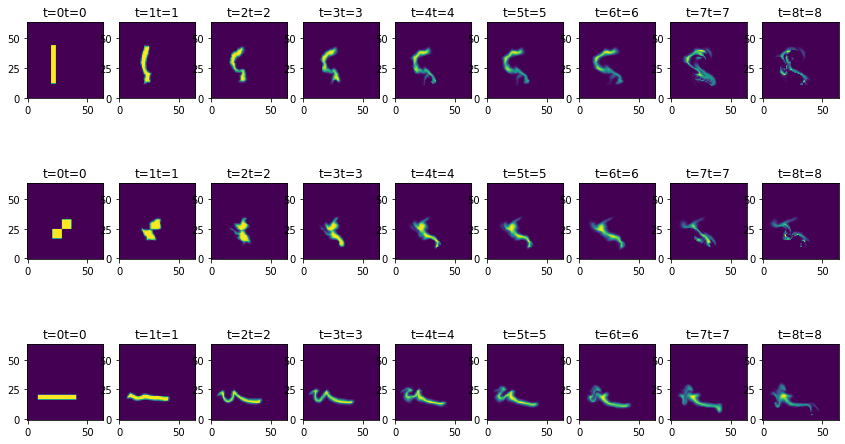

In [22]:
import pylab
batches = [0, 1, 2]
pylab.subplots(len(batches), 9, sharey='row', sharex='col', figsize=(12, 7))
pylab.tight_layout(w_pad=0)
for i, batch in enumerate(batches):
    for t in range(9):
        pylab.subplot(len(batches), 9, t + 1 + i * 9)
        pylab.title('t=%d' % t * 2)
        pylab.imshow(states[t * 2].density.data[batch, ..., 0], origin='lower')


**TODO, show targets; discuss**


## Next Steps

- Change the `test_range` indices to look at different examples, and test the generalization of the trained controller networks.
- Try using a `RefinedSequence` (instead of a `StaggeredSequence`) to train with the prediction refinement scheme. This will yield a further improved control.